# Solving a one-asset HANK model in sequence space
In this notebook we show how to
1. [Adapt general HA blocks to specific models](#1-hetblock)
2. [Solve for a steady state with multiple calibration targets](#2-calibration)
3. [Compute linearized impulse responses: unwrap convenience function](#3-linear)
4. [Compute nonlinear impulse responses: quasi-Newton performs well even for large nonlinearities](#4-nonlinear)
5. [Check local determinacy](#5-determinacy)

This notebook accompanies the working paper by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.


The model is a HA version of the textbook New Keynesian model. Technology is linear in labor, prices are sticky á la Rotemberg, and monetary policy follows a Taylor rule. For a detailed description of the model, please see the paper. As a reminder, the model can be summarized in sequence form as

$$
\textbf{H}_t(\textbf{Y}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the endogenous variables are $\textbf{Y} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$. 

The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation

$$
\begin{align} \tag{HH}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \sum_{e'}V_{t+1}(e', a) \mathcal{P}(e,e') \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends. 

We can think of the model as a directed acyclical graph (DAG) with **3 endogenous inputs**

![Directed Acyclical Graph](figures/hank1_dag.png) 

and write it as an implicit function

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

## 0 Import packages
The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
import jacobian as jac
import nonlinear
import hank
import determinacy as det

<a id="1-hetblock"></a>

## 1 Adapting HA blocks with hetinput attachments

As we have seen in the Krusell-Smith notebook, the main task in setting up HA blocks is to write a backward iteration function that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration. For the standard income fluctuation problem with endogenous labor supply we're dealing with here, the endogenous gridpoint method of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice.

Solving the endogenous-labor problem via EGM is standard but somewhat tedious and so the details are left to ``hank.py``. Instead we will focus on a new feature that makes it much easier to adapt HetBlocks to different macro enviroments.

The backward iteration function `hank.household` corresponds to the general problem:

$$
\begin{align} \tag{HH-general}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \sum_{e'}V_{t+1}(e', a) \mathcal{P}(e,e') \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n + T_t(e)
\\
a &\geq 0
\end{align}
$$

That is, households take as given the sequence of interest rates $r_t$, wages $w_t$ and skill-specific transfers $T_t(e).$ In the context of this particular HANK model, transfers equal dividends minus taxes. But it's easy to imagine many other cases. Rather than writing a specific backwatd iteration function for each of them, we can just supply a function that specifies how the $\{r_t, w_t, T_t(e)\}$ are determined in this particular case. We refer such functions as **hetinput**. 


Since $r_t$ and $w_t$ correspond directly to aggregate variables of the model, we only have to specify transfers:

In [4]:
def transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule):    
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

Let's attach this hetinput function to the generic household HetBlock using (the aptly-named) ``HetBlock.attach_hetinput`` method.

In [3]:
household = hank.household.attach_hetinput(transfers)

Each HetBlock can be associated with at most one hetinput. Once it is attached, every call to the HetBlock will be routed through the hetinput function first.

<a id="2-calibration"></a>

## 2 Calibrating the steady state
Similarly to the RBC example, we calibrate the discount factor $\beta$ and disutility of labor $\varphi$ to hit a target fot the interest rate and effective labor $L=1.$

This is a two-dimensional rootfinding problem that we solve by Broyden's method, which we implemented in ``utils.py``. It takes a function $f: \mathbb{R}^n \to \mathbb{R}^n$ and an initial guess for its roots, $x_0 \in \mathbb{R}^n$, and backtracks whenever $f$ returns a `ValueError`.

The calibration has two substantive steps. First, express analytically all variables that don't depend on $(\beta, \varphi).$ Second, construct the residual function that takes the current guesses $(\beta, \varphi)$ and maps them into deviations from he calibration targets. This just requires an evaluation of the household block. The rootfinder does the rest. 

Although additional efficiency gains would be possible here (for instance, by updating our initial guesses for policy and distribution along the way), we will not implement them, since they are not our focus here.

In [4]:
def hank_ss(beta_guess=0.986, vphi_guess=0.8, r=0.005, eis=0.5, frisch=0.5, mu=1.2, B_Y=5.6, rho_s=0.966, sigma_s=0.5,
            kappa=0.1, phi=1.5, nS=7, amax=150, nA=500, tax_rule=None, div_rule=None):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)
    
    # default incidence rules are proportional to skill
    if tax_rule is None:
        tax_rule = e_grid  # scale does not matter, will be normalized anyway
    if div_rule is None:
        div_rule = e_grid
    assert len(tax_rule) == len(div_rule) == len(e_grid), 'Incidence rules are inconsistent with income grid.'

    # solve analytically what we can
    B = B_Y
    w = 1 / mu
    Div = (1 - w)
    Tax = r * B
    T = transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule)

    # initialize guess for policy function iteration
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis] + T[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta_loc, eis=eis,
                           Div=Div, Tax=Tax, frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc,
                           tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
        return np.array([out['A'] - B, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation for reporting
    c_const, n_const = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi, Va)
    ss = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta, eis=eis,
                      Div=Div, Tax=Tax, frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const,
                      tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
    
    # check Walras's law
    walras = 1 - ss['C']
    assert np.abs(walras) < 1E-8
    
    # add aggregate variables
    ss.update({'B': B, 'phi': phi, 'kappa': kappa, 'Y': 1, 'rstar': r, 'Z': 1, 'mu': mu, 'L': 1, 'pi': 0,
               'walras': walras, 'ssflag': False})
    return ss

Let's solve for the steady state using our default calibration, and plot the labor supply policy as function of assets for each skill type. In general, poorer and more productive households choose to work more. 

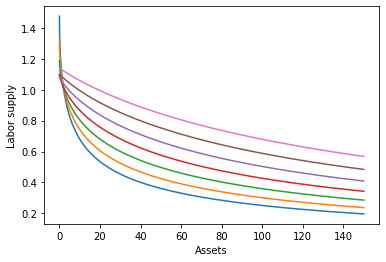

In [5]:
ss = hank_ss()
plt.plot(ss['a_grid'], ss['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

<a id="3-linear"></a>

## 3 Linearized dynamics using Jacobians
Recall that we reduced the to the following DAG:

![Directed Acyclical Graph](figures/hank1_dag.png) 

that can also be written as an implicit equation

$$
H(\pi, Y, w; r^*, Z) =
\begin{pmatrix}
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{L}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0\end{pmatrix},
$$

to be solved for $U=(\pi, w, Y)$ given any $Z=(Z, r^*)$. The rest of the endogenous variables are be obtained as explicit functions of $(\pi, w, Y; Z, r^*)$ along the DAG, but it would be tedious to write them out.

Keep in mind that the implicit function theorem implies that the response of unknowns is

$$
dU = \underbrace{-H_U^{-1}H_Z}_{G_U} dZ \tag{1}
$$

Recall that we already solved for a steady state and stored is as `ss`. Furthermore, we will use a 300-period truncation horizon. 

### 3.1 Define simple blocks

In [6]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return L, Div

@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, B):
    Tax = r * B
    return Tax

@simple
def mkt_clearing(A, NS, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NS - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc_res

### 3.2 Cut to the chase
The surest way to obtain the general equilibrium Jacobians is to use the `get_G` convenience function. Notice the `save=True` option. This means that we're saving the HA Jacobians calculated along the way for later use.

In [7]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
block_list = [firm, monetary, fiscal, nkpc, mkt_clearing, household] 
G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

### 3.3 Break down `get_G`

Under the hood, the very powerful `jac.get_G` performs the following steps:
 - orders the blocks so that we move forward along the model's DAG
 - computes the partial Jacobians $\mathcal{J}^{o,i}$ from all blocks (if their Jacobian is not supplied already), only with respect to the inputs that actually change: unknowns, exogenous shocks, outputs of earlier blocks
 - forward accumulates partial Jacobians $\mathcal{J}^{o,i}$ to form total Jacobians $\mathbf{J}^{o,i}$
 - packs $\mathbf{J}^{o,i}$ to form $\mathbf{H_U}$ and $\mathbf{H_Z}$
 - solves for the GE Jacobians for unknowns $\mathbf{G_U} = \mathbf{H_U}^{-1}\mathbf{H_Z}$
 - forward accumulates GE Jacobians to obtain $\mathbf{G}$ for other endogenous variables 
 
Let's take a closer look at each.

#### Step 1: Topological sort and partial Jacobians
By looking at the inputs and outputs of each block, we can order them so that we only move forward on the DAG (this is called a **topological sort**). Knowing the DAG is a prerequisite for all that follows, and also allows us to avoid wasteful Jacobian calculations: we only need Jacobians with respect to unknowns, exogenous, and outputs of earlier blocks.

In [8]:
curlyJs, required = jac.curlyJ_sorted(block_list, unknowns+exogenous, ss, T)

The first output `curlyJs` is a list of nested dictionaries. Each entry in the list contains all the necessary Jacobians for the corresponding block. Blocks are ordered according to the topological sort.

For example, the first block is `monetary`, because it only takes an unknown $\pi$ and an exogenous $r^*$ as inputs. Let's take a look. 

In [9]:
print(curlyJs[0])

{'r': {'rstar': SimpleSparse({(-1, 0): 1.000}), 'pi': SimpleSparse({(0, 0): -1.005, (-1, 0): 1.500})}}


Since this is a simple block, the Jacobians are represented as a instances of the `SimpleSparse` class. Note that `jac.curlyJ_sorted` correctly determined that it is not necessary to differentiate with respect to the Taylor rule parameter $\phi$ (if we wanted to consider shocks to this parameter, we'd just have to include it among the exogenous inputs.)

The second output `required` is a set of extra variables (not unknowns and exogenous) that we have to differentiate with respect to, because they are outputs of some blocks and inputs of others. 

In [10]:
print(required)

{'NS', 'A', 'Tax', 'L', 'Div', 'C', 'r'}


#### Step 2: Compose Jacobians along the DAG
We're interested in the Jacobians with respect to the inputs of $H$, i.e. the unknowns $(\pi, w, Y)$ and the shocks $(r^*, Z).$  

First, we apply the chain rule by using `jac.forward_accumulate`. This gives the $T \times T$ building blocks of the $H_U$ and $H_Z$ that relate targets to unknowns and exogenous. 

In [11]:
J_curlyH_U = jac.forward_accumulate(curlyJs, unknowns, targets, required)
J_curlyH_Z = jac.forward_accumulate(curlyJs, exogenous, targets, required)
print(J_curlyH_U.keys())
print(J_curlyH_U['asset_mkt'].keys())

dict_keys(['nkpc_res', 'asset_mkt', 'labor_mkt'])
dict_keys(['w', 'pi', 'Y'])


Next, we just have to pack them into two (big) matrices. These capture (to first order) the implicit relationship between unknowns $X=(\pi, w, Y)$ induced by the requirement that markets clear and the Phillips curve holds, i.e. that the targets of the DAG evaluate to zero.

In [12]:
H_U = jac.pack_jacobians(J_curlyH_U, unknowns, targets, T)
H_Z = jac.pack_jacobians(J_curlyH_Z, exogenous, targets, T)
print(H_U.shape)
print(H_Z.shape)

(900, 900)
(900, 600)


#### Step 3: General equilibrium Jacobians
First we can get the response of unknowns directly by the implicit function theorem.

In [13]:
G_U = jac.unpack_jacobians(-np.linalg.solve(H_U, H_Z), exogenous, unknowns, T)
print(G_U.keys())

dict_keys(['pi', 'w', 'Y'])


And the rest can be obtained by forward accumulation that accounts for the direct and indirect effects alike.

In [14]:
curlyJs = [G_U] + curlyJs
outputs = set().union(*(curlyJ.keys() for curlyJ in curlyJs)) - set(targets)

G2 = jac.forward_accumulate(curlyJs, exogenous, outputs, required | set(unknowns))

### 3.4 Results
First let's check that we have correctly reconstructed the steps of `jac.get_G`.

In [15]:
for o in G:
    for i in G[o]:
        assert np.allclose(G[o][i], G2[o][i])

Now let's consider 25 basis point monetary policy shocks with different persistences and plot the response of inflation.

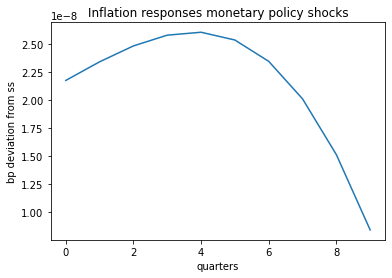

In [31]:
rhos = np.array([0.2])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar

plt.plot(10000 * dpi[290:])
plt.title(r'Inflation responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

<a id="4-nonlinear"></a>

## 4. Nonlinear dynamics
Conceptually there's nothing new in this section compared to the Krusell-Smith notebook. We're going to implement a quasi-Newton algorithm to solve for the unknown sequences $U=(\pi, w, Y)$ given some sequences of shocks $(r^*, Z).$ We initialize the algorithm by the naive guess that the variables in $U$ stay constant at their steady-state level. Then we evaluate the DAG and update the guess using the inverse Jacobian $H_U^{-1}.$ The algorithm converges in a few steps, despite the presence of substantial nonlinearities.

### 4.1 A typical monetary policy shock
Note that the linearized solution ignores price adjustment costs. For a monetary policy shock of typical size and persistence, this does not really matter.   

In [17]:
rho_r, sig_r = 0.61, -0.01/4
drstar = sig_r * rho_r ** (np.arange(T))
rstar = ss['r'] + drstar

H_U = jac.get_H_U(block_list, unknowns, targets, T, ss, use_saved=True)
H_U_factored = utils.factor(H_U)

td_nonlin = nonlinear.td_solve(ss, block_list, unknowns, targets, H_U_factored=H_U_factored,rstar=rstar)

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.46E-02
   max error for labor_mkt is 2.73E-03
On iteration 1
   max error for nkpc_res is 1.16E-06
   max error for asset_mkt is 1.33E-04
   max error for labor_mkt is 6.89E-06
On iteration 2
   max error for nkpc_res is 4.81E-08
   max error for asset_mkt is 2.21E-06
   max error for labor_mkt is 1.42E-07
On iteration 3
   max error for nkpc_res is 1.26E-09
   max error for asset_mkt is 3.46E-08
   max error for labor_mkt is 8.41E-10
On iteration 4
   max error for nkpc_res is 2.10E-11
   max error for asset_mkt is 5.01E-10
   max error for labor_mkt is 1.26E-11


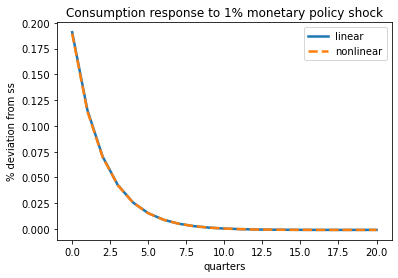

In [18]:
dC_lin = 100 * G['C']['rstar'] @ drstar / ss['C']
dC_nonlin = 100 * (td_nonlin['C']/ss['C'] - 1) 

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

### 4.2 A very large monetary policy shock
However, the nonlinearities may become substantial for very large or persistent monetary policy shocks. Reassuringly, the Jacobian still works well as an updating rule. The quasi-Newton method for a 10% monetary policy shock (extremely large!) still converges below in just 9 iterations, despite nonlinearities evident in the results.

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.41E-01
   max error for labor_mkt is 2.68E-02
On iteration 1
   max error for nkpc_res is 9.66E-05
   max error for asset_mkt is 1.30E-02
   max error for labor_mkt is 5.55E-04
On iteration 2
   max error for nkpc_res is 2.62E-05
   max error for asset_mkt is 2.19E-03
   max error for labor_mkt is 7.31E-04
On iteration 3
   max error for nkpc_res is 3.84E-06
   max error for asset_mkt is 3.80E-04
   max error for labor_mkt is 9.03E-05
On iteration 4
   max error for nkpc_res is 1.50E-06
   max error for asset_mkt is 6.39E-05
   max error for labor_mkt is 1.83E-05
On iteration 5
   max error for nkpc_res is 1.26E-07
   max error for asset_mkt is 1.05E-05
   max error for labor_mkt is 2.52E-06
On iteration 6
   max error for nkpc_res is 3.47E-08
   max error for asset_mkt is 1.72E-06
   max error for labor_mkt is 4.66E-07
On iteration 7
   max error for nkpc_res is 3.43E-09
   max error for asset_mkt is 

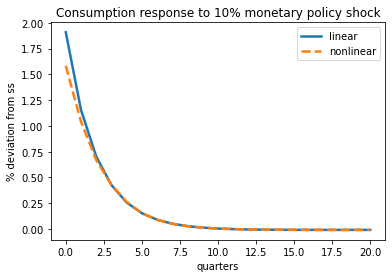

In [19]:
rho_r, sig_r = 0.61, -0.10/4
drstar = sig_r * rho_r ** (np.arange(T))
rstar = ss['r'] + drstar

td_nonlin = nonlinear.td_solve(ss, block_list, unknowns, targets, H_U_factored=H_U_factored, rstar=rstar)

dC_lin = 100 * G['C']['rstar'] @ drstar / ss['C']
dC_nonlin = 100 * (td_nonlin['C']/ss['C'] - 1) 

plt.plot(dC_lin[:21], label='linear', linestyle='-', linewidth=2.5)
plt.plot(dC_nonlin[:21], label='nonlinear', linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 10% monetary policy shock')
plt.xlabel('quarters')
plt.ylabel('% deviation from ss')
plt.legend()
plt.show()

<a id="5-determinacy"></a>

## 5. Local determinacy
Local determinacy boils down to the invertibility of the matrix $H_U$. The steady state is a locally-determinate equilibrium if and only if $H_U$ is invertible. 

**Numerical approach.** In practice, $H_U$ is obtained numerically for a finite horizon, and thus we can never expect it to be exactly singular, even if equilibrium is indeterminate. Still, near-singularity of $H_U$, especially when it becomes more drastic as the truncation horizon $T$ is increased, is a likely indication of indeterminacy.

In practice, we have found that indeterminacy is best detected by looking at the last few singular values: if the smallest is discontinuously smaller than the second and third smallest, then indeterminacy is likely.

**Our contribution: winding number criterion.** A better solution is to use the winding number criterion introduced in our paper, which rapidly gives an exact answer. This criterion exploits the "asymptotic time invariant" structure of the Jacobians in SHADE models: within each Jacobian, each diagonal eventually converges to some constant, and these constants are close to zero far enough away from the main diagonal.

Given knowledge of the asymptotic structure of $H_U$, which is encoded in an array $A$, the criterion calculates the "winding number" of the curve

$$
\det A(\lambda) = \det\sum_{j=-\infty}^\infty A_j e^{ij\lambda} \tag{1}
$$

as $\lambda$ varies from $0$ to $2\pi$. Here, $A_j$ is the $n_u\times n_u$ matrix representing the asymptotic value on the $j$th diagonal above the main diagonal for all pairs of targets and unknowns. The "winding number" is the number of times the curve (1) wraps counterclockwise around the origin in the complex plane.

A winding number of 0 indicates that the model has a unique solution around the steady state, while a winding number of -1 or less indicates indeterminacy.

**Example in our HANK model.** As it is well-known, determinacy in the New Keynesian models requires that the interest rate rule is sufficiently responsive to inflation. Therefore, we're going to illustrate the issue by varying the parameter $\phi$ and tracing its effect on $H_U.$

### 5.1 Stable case
Let's start with the the baseline calibration with $\phi=1.5$. Both approaches show the model is determinate, as expected.

In [20]:
# smallest singular values
_, s, _ = np.linalg.svd(H_U)
print(f'Smallest singular values: {s[-3]:.4f}, {s[-2]:.4f}, {s[-1]:.4f}')

# winding number test
# first, use get_H_U with asymptotic=True to get array A representing asymptotic H_U
A = jac.get_H_U(block_list, unknowns, targets, T, ss, asymptotic=True, save=True, use_saved=True)

# then apply winding number criterion
wn = det.winding_criterion(A)
print(f'Winding number: {wn}')

Smallest singular values: 0.0720, 0.0715, 0.0715
Winding number: 0


### 5.2 Unstable case
Let's see what happens with $\phi=0.75$. First of all, we'll have to recompute the Jacobian. It's important to realize that $\phi$ does not affect the steady state, and affects dynamics only through the monetary block. Thus, recomputing the Jacobians of the household block would be wasteful. We can avoid this by setting ``use_saved=True``. 

In [21]:
ss2 = {**ss, 'phi': 0.75}
H_U2 = jac.get_H_U(block_list, unknowns, targets, T, ss2, use_saved=True)

This time both tests reveal clear indeterminacy: the smallest singular value is discontinuously smaller than the others, and the winding number is -1.

In [22]:
# smallest singular values
_, s2, _ = np.linalg.svd(H_U2)
print(f'Smallest singular values: {s2[-3]:.4f}, {s2[-2]:.4f}, {s2[-1]:.4f}')

# winding number
A2 = jac.get_H_U(block_list, unknowns, targets, T, ss2, asymptotic=True, use_saved=True)
wn2 = det.winding_criterion(A2)
print(f'Winding number: {wn2}')

Smallest singular values: 0.0967, 0.0960, 0.0000
Winding number: -1


Not surprisingly, if we tried to use this Jacobian to compute impulse responses, we'd fail. (We'll wrap in a try/except block to avoid a giant error message.)

In [23]:
try:
    td_nonlin = nonlinear.td_solve(ss2, block_list, unknowns, targets, H_U=H_U2,rstar=rstar)
except ValueError as e:
    print(e)

On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.41E-01
   max error for labor_mkt is 2.68E-02


<ipython-input-6-c838c562b067>:26: RuntimeWarning: invalid value encountered in log
  nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
<ipython-input-6-c838c562b067>:4: RuntimeWarning: invalid value encountered in log
  Div = Y - w * L - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y


Cannot solve constrained household's problem: No convergence after 30 iterations!


In fact, it fails after the first iteration: since the Jacobian is nearly singular, using its inverse in Newton's method leads to a very large step to the next guess, which then is outside the admissible domain and leads to an error within the household routine.

### 5.3 Why use the winding number criterion?

It's very fast and precise. We can use bisection, for instance, to get the exact threshold at which the model becomes determinate. It turns out that this is at approximately $\phi=1.005$.

In [24]:
phi_low = 0.8
phi_high = 1.2
while phi_high - phi_low > 1E-6:
    phi_mid = (phi_low + phi_high)/2
    ss_cur = {**ss, 'phi': phi_mid}
    A_cur = jac.get_H_U(block_list, unknowns, targets, T, ss_cur,
                                        asymptotic=True, use_saved=True)
    wn_cur = det.winding_criterion(A_cur)
    if wn_cur == 0:
        phi_high = phi_mid
    else:
        phi_low = phi_mid
phi_threshold = (phi_low + phi_high)/2
print(f'Threshold for determinacy: phi={phi_threshold:.3f}')

Threshold for determinacy: phi=1.005


We can compare to the results from looking at singular values. Specifically, we'll look at the ratio of the smallest to the second-smallest singular value for a range of $\phi$ around the determinacy threshold we've identified.

This takes several seconds, because the singular value decomposition is costly and we need to redo it for every $\phi$.

In [25]:
# non-uniform grid of phis to get extra precision near
# where we know from winding number test the threshold lies
phis = np.unique(np.concatenate((np.linspace(0.99, 1.00, 5),
                                 np.linspace(1.00, 1.01, 10),
                                 np.linspace(1.01, 1.02, 5))))

sv_ratio = np.empty_like(phis)
for it, phi in enumerate(phis):
    ss_cur = {**ss, 'phi': phi}
    H_U_cur = jac.get_H_U(block_list, unknowns, targets, T, ss_cur, use_saved=True)

    _, s, _ = np.linalg.svd(H_U_cur)
    sv_ratio[it] = s[-1] / s[-2]

Let's plot this ratio against the winding number plus 1, which jumps up at the determinacy threshold we've already calculated.

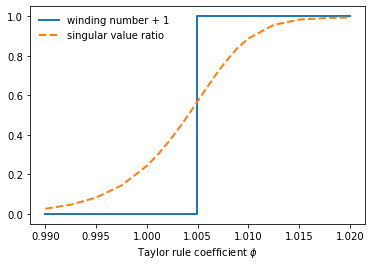

In [26]:
# winding number plus 1 jumps up at phi_threshold
phis_wn = [phis[0], phi_threshold, phi_threshold, phis[-1]]
wns = [0, 0, 1, 1]

plt.plot(phis_wn, wns, linewidth=2, label=r'winding number + 1')
plt.plot(phis, sv_ratio, linewidth=2, label=r'singular value ratio', linestyle='--')
plt.legend(framealpha=0)
plt.xlabel(r'Taylor rule coefficient $\phi$');

We see that the two approaches give consistent answers, but the winding number approach is far more precise and immediate.

### 5.4 Visualizing the winding number criterion
To see how this works, we can also directly plot the curve $\det A(\lambda)$ for which we're taking the winding number. The function `det.detA_path`, which is called by `det.winding_criterion` under the hood, provides this.

**Indeterminate case.** First let's do so for an indeterminate case $\phi=1.001$.

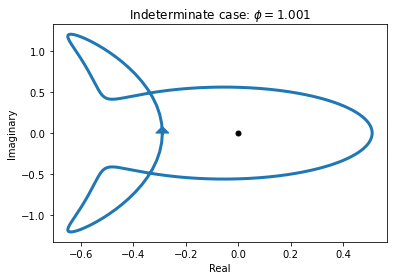

In [27]:
phi = 1.001
ss_cur = {**ss, 'phi': phi}
A_cur = jac.get_H_U(block_list, unknowns, targets, T, ss_cur,
                    asymptotic=True, use_saved=True)

det_Alambda = det.detA_path(A_cur)
x, y = det_Alambda.real, det_Alambda.imag

# plot curve
plt.plot(x, y, label=r'$\det A(\lambda)$', linewidth=3);

# dot for origin
plt.plot(0, 0, marker='o', markersize=5, color="black")

# arrow to show orientation (using rate of change around lambda=0)
plt.arrow(x[0], y[0], 0.001*(x[1]-x[-2]), 0.001*(y[1]-y[-2]), color='C0',
          width=0.0001, head_width=0.05, head_length=0.08)
plt.title(r'Indeterminate case: $\phi=1.001$')
plt.xlabel(r'Real')
plt.ylabel(r'Imaginary');

We clearly see the winding number of -1 here, corresponding to a single clockwise trajectory around the origin.

**Determinate case.** Now let's try the same for $\phi=1.007$.

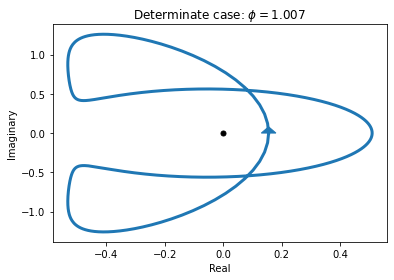

In [28]:
phi = 1.007
ss_cur = {**ss, 'phi': phi}
A_cur = jac.get_H_U(block_list, unknowns, targets, T, ss_cur,
                    asymptotic=True, use_saved=True)

det_Alambda = det.detA_path(A_cur)
x, y = det_Alambda.real, det_Alambda.imag

# plot curve
plt.plot(x, y, label=r'$\det A(\lambda)$', linewidth=3);

# dot for origin
plt.plot(0, 0, marker='o', markersize=5, color="black")

# arrow to show orientation (using rate of change around lambda=0)
plt.arrow(x[0], y[0], 0.001*(x[1]-x[-2]), 0.001*(y[1]-y[-2]), color='C0',
          width=0.0001, head_width=0.05, head_length=0.08)
plt.title(r'Determinate case: $\phi=1.007$')
plt.xlabel(r'Real')
plt.ylabel(r'Imaginary');

Here the winding number is zero: the curve has shifted such that it no longer wraps around the origin at all.